In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
from pavel_shtykov import * 
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import rescale
from skimage.color import rgb2gray
from skimage.util import img_as_ubyte
import seaborn as sns
import pandas as pd

In [2]:
! ls

1644893131_2-kartinkin-net-p-pikselnie-kartinki-2.png
BMML_practice_2.pdf
__pycache__
alexandr_kuzmin
background.jpeg
data_vmk22_100.npy
data_vmk22_1000.npy
data_vmk22_300.npy
data_vmk22_50.npy
data_vmk22_500.npy
df_res_1.pickle
dict_res_1.pickle
expirements.ipynb
face.png
open_test.py
prototypes.py
res
sanya_solve.py
save_vor.pickle
sfnvsfhvsh.py
test.ipynb


<ipython-input-3-447b53dbdc68>:4: FutureWarning: `multichannel` is a deprecated argument name for `rescale`. It will be removed in version 1.0. Please use `channel_axis` instead.
  img_down = rescale(img_small, 0.017, anti_aliasing=False,   multichannel=True)


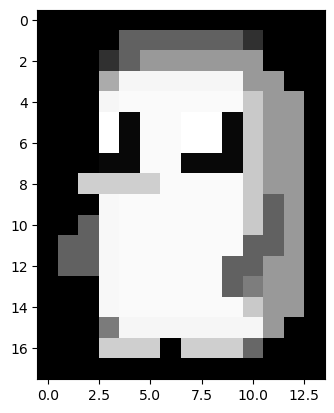

In [3]:
img = imread('face.png')

img_small = img[200:1250, 100:900]
img_down = rescale(img_small, 0.017, anti_aliasing=False,   multichannel=True)

img_only = img_down[:, :, :3]
img_only = rgb2gray(img_only)
mask = img_down[:, :, 3] > 0 
img_only = img_as_ubyte(img_only)

plt.imshow(img_only, cmap='gray')

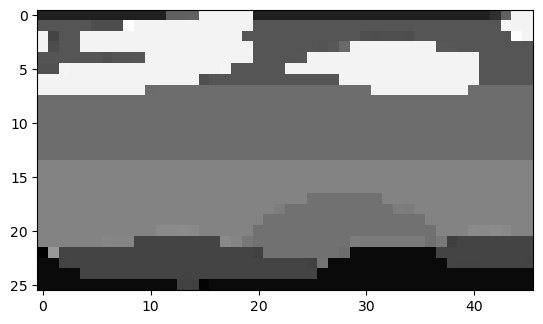

In [4]:
bg = imread('background.jpeg')
bg = rgb2gray(bg)
bg = rescale(bg, 0.018, anti_aliasing=False)
bg = (bg - bg.min()) / (bg.max() - bg.min())
bg = img_as_ubyte(bg)

plt.imshow(bg , cmap='gray')

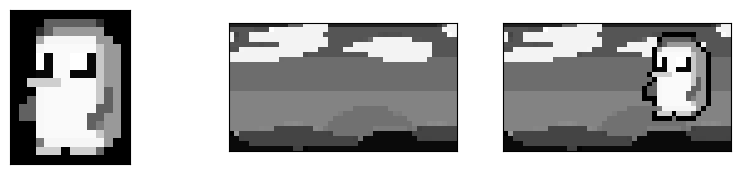

In [21]:
fig, ax = plt.subplots(1, 3, squeeze=False)
fig.set_figwidth(10)
fig.set_figheight(2)


ax[0][0].imshow(img_only, cmap='gray')
ax[0][1].imshow(bg, cmap='gray')
ax[0][2].imshow(true_img[:, :, 0], cmap='gray')
# ax[1][i].set_axis_off()

for i in range(3):
    ax[0][i].tick_params(
        axis='both',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        left=False,
        right=False,
        labelbottom=False,
        labelleft=False
    )

plt.savefig('res/bg_face.png')

In [5]:
H, W = bg.shape
h, w = img_only.shape

In [6]:
def gen(num, s):
    print(num, s)
    
    true_img = []
    noise_imgs = []
    xy_img = []
    s_true = s

    for i in range(num):
        curr_img = bg.copy()
        
        x = int(np.random.choice(np.arange(0, H - h + 1, dtype=np.int32), size=1))
        y = int(np.random.choice(np.arange(0, W - w + 1, dtype=np.int32), size=1))

        curr_img[x:x+h, y:y+w][mask] = 0
        curr_img[x:x+h, y:y+w] += img_only

        curr_noise = np.random.normal(curr_img, s_true, size=curr_img.shape)
        curr_noise = (curr_noise - curr_noise.min()) / (curr_noise.max() - curr_noise.min())
        curr_noise = img_as_ubyte(curr_noise)

        true_img.append(curr_img)
        noise_imgs.append(curr_noise)
        xy_img.append([x, y])

    # plt.imshow(true_img[-1], cmap='gray')    
    # plt.show()

    # plt.imshow(noise_imgs[-1], cmap='gray')    
    # plt.show()

    true_img = np.einsum('ijk->jki', np.array(true_img)).astype(float)
    noise_imgs = np.einsum('ijk->jki', np.array(noise_imgs)).astype(float)
    xy_img = np.einsum('ij->ji', np.array(xy_img))

    return noise_imgs, true_img, xy_img

In [16]:
noise_imgs, true_img, xy_img = gen(100, 100)
res = [run_EM(noise_imgs, h, w) for _ in range(7)]


100 100


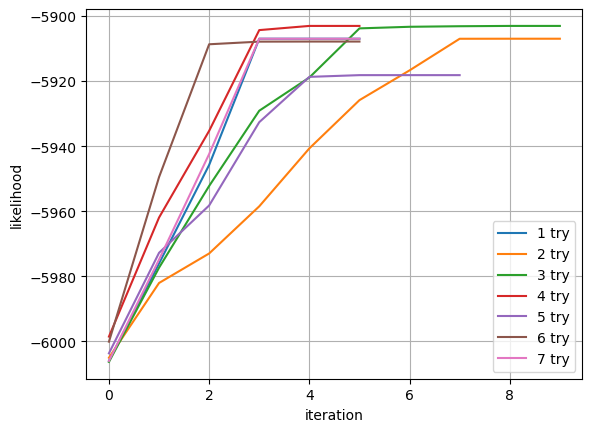

In [14]:
for i, r in enumerate(res):   
    plt.plot(np.array(r[-1]) / 100, label=f'{i+1} try')
plt.xlabel('iteration')
plt.ylabel('likelihood')
plt.legend()
plt.grid()
# plt.savefig('res/ll_for_multi.svg')

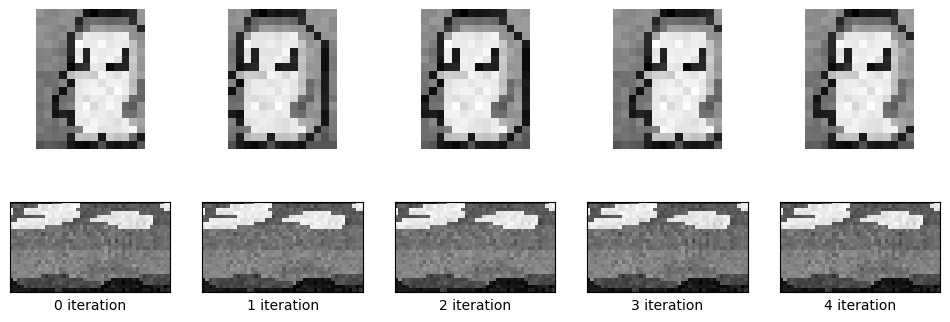

In [189]:
plt.close('all')

fig, ax = plt.subplots(2, 5)
fig.set_figwidth(12)
fig.set_figheight(4)

for i in range(5):
    ax[0][i].imshow(res[i][0], cmap='gray')
    ax[1][i].imshow(res[i][1], cmap='gray')
    ax[1][i].set_xlabel(f'{i} iteration')
    ax[0][i].set_axis_off()
    # ax[1][i].set_axis_off()

    ax[1][i].tick_params(
        axis='both',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        left=False,
        right=False,
        labelbottom=False,
        labelleft=False
    )
fig.savefig('res/B_F_mult_starts.png')

In [190]:
df_res_1 = pd.DataFrame()
dict_res_1 = {}

for s in [20, 50, 100, 150, 200, 500, 1000]:
    for num in [10, 30, 70, 100, 150, 350, 1000]:
        curr_res = run_EM_with_restarts(gen(num, s)[0], h, w, n_restarts=3)
        df_res_1.at[s, num] = curr_res[-1]
        dict_res_1[(s, num)] = curr_res

10 20
30 20
70 20
100 20
150 20
350 20
1000 20


In [ ]:
sns.heatmap(df_res_1 / df_res_1.columns, cmap=sns.color_palette("coolwarm", as_cmap=True))
plt.xlabel('Количество изображений')
plt.ylabel('s')
# plt.savefig('res/heatmap_s_num.svg')

In [ ]:
plt.close('all')

fig, ax = plt.subplots(2, 5)
fig.set_figwidth(12)
fig.set_figheight(4)

for i, s in enumerate([20, 50, 100, 150, 500]):
    ax[0][i].imshow(dict_res_1[(s, 70)][0], cmap='gray')
    ax[1][i].imshow(dict_res_1[(s, 70)][1], cmap='gray')
    ax[1][i].set_xlabel(f's = {s}')
    ax[0][i].set_axis_off()
    # ax[1][i].set_axis_off()

    ax[1][i].tick_params(
        axis='both',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        left=False,
        right=False,
        labelbottom=False,
        labelleft=False
    )
# fig.savefig('res/slice_on_s_num_70.png')

In [ ]:
plt.close('all')

fig, ax = plt.subplots(2, 5)
fig.set_figwidth(12)
fig.set_figheight(4)

for i, num in enumerate([70, 100, 150, 350, 1000]):
    ax[0][i].imshow(dict_res_1[(500, num)][0], cmap='gray')
    ax[1][i].imshow(dict_res_1[(500, num)][1], cmap='gray')
    ax[1][i].set_xlabel(f'num_imgs = {num}')
    ax[0][i].set_axis_off()
    # ax[1][i].set_axis_off()

    ax[1][i].tick_params(
        axis='both',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        left=False,
        right=False,
        labelbottom=False,
        labelleft=False
    )
# fig.savefig('res/slice_on_num_s_500.png')

In [ ]:
noise_2, _, _ = gen(50, 100)

res_2_full = run_EM_with_restarts(noise_2, h, w)
res_2_map = run_EM_with_restarts(noise_2, h, w, use_MAP=True)


fig, ax = plt.subplots(2, 2)
fig.set_figwidth(7)
fig.set_figheight(4)

ax[0][0].imshow(res_2_full[0], cmap='gray')
ax[1][0].imshow(res_2_full[1], cmap='gray')
ax[1][0].set_xlabel(f'use_map = False')

ax[0][1].imshow(res_2_map[0], cmap='gray')
ax[1][1].imshow(res_2_map[1], cmap='gray')
ax[1][1].set_xlabel(f'use_map = True')

for i in range(2):
    for j in range(2):
        ax[i][j].tick_params(
            axis='both',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            left=False,
            right=False,
            labelbottom=False,
            labelleft=False
        )

# fig.savefig('res/map_s_100_num_50.png')

In [ ]:
res_3 = []

for i in [50, 100, 300, 500, 1000]:
    print(i)
    big_imgs = np.load(f'data_vmk22_{i}.npy')
    res_3.append(run_EM(big_imgs, h=100, w=67))

In [ ]:
plt.close('all')

fig, ax = plt.subplots(2, 5)
fig.set_figwidth(12)
fig.set_figheight(4)

for i, num in enumerate([50, 100, 300, 500, 1000]):
    ax[0][i].imshow(res_3[i][0], cmap='gray')
    ax[1][i].imshow(res_3[i][1], cmap='gray')
    ax[1][i].set_xlabel(f'num_imgs = {num}')
    ax[0][i].set_axis_off()
    # ax[1][i].set_axis_off()

    ax[1][i].tick_params(
        axis='both',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        left=False,
        right=False,
        labelbottom=False,
        labelleft=False
    )
# fig.savefig('res/vor_all.png')